In [1]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
from matplotlib.transforms import Affine2D
import matplotlib.patches as patches
%matplotlib inline
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format

In [2]:
pentagon = mpath.Path.unit_regular_polygon(5)
hexagon = mpath.Path.unit_regular_polygon(6)
circle = mpath.Path.unit_circle()

In [3]:
pentagon_vertices = pentagon.vertices
pentagon_codes = pentagon.codes
circle_vertices = circle.vertices
circle_codes = circle.codes
hexagon_vertices = hexagon.vertices
hexagon_codes = hexagon.codes

In [4]:
hexagon_len = ((hexagon_vertices[0,0] - hexagon_vertices[1,0])**2+
               (hexagon_vertices[0,1] - hexagon_vertices[1,1])**2)**(0.5)

In [5]:
pentagon_len = ((pentagon_vertices[0,0] - pentagon_vertices[1,0])**2+
                (pentagon_vertices[0,1] - pentagon_vertices[1,1])**2)**(0.5)

In [6]:
scale_hexagon = 0.45
scale_pentagon = scale_hexagon*hexagon_len/pentagon_len

In [7]:
hexagon_vertices = hexagon_vertices * scale_hexagon
pentagon_vertices =pentagon_vertices * scale_pentagon

In [8]:
h = 0.28125
angle = np.radians((360 - (108 + 90 + 90))/2)
o = np.sin(angle)*h
a = np.cos(angle)*h
a_2 = 4/3*a
hexagon1_vertices = np.zeros((7,2))
hexagon1_vertices[0] = pentagon_vertices[2]
hexagon1_vertices[-1] = pentagon_vertices[2]
hexagon1_vertices[-2] = pentagon_vertices[3]
hexagon1_vertices[1] = hexagon1_vertices[0] - np.array([o,a])
hexagon1_vertices[2] = hexagon1_vertices[1] - np.array([-o,a_2])
hexagon1_vertices[3] = hexagon1_vertices[2] - np.array([-0.45,0])
hexagon1_vertices[4] = hexagon1_vertices[3] - np.array([-o,-a_2])
hex1 = mpath.Path(hexagon1_vertices, hexagon_codes)
hexagon2_vertices = hex1.transformed(Affine2D().rotate_deg(72)).vertices
hexagon3_vertices = hex1.transformed(Affine2D().rotate_deg(144)).vertices
hexagon4_vertices = hex1.transformed(Affine2D().rotate_deg(216)).vertices
hexagon5_vertices = hex1.transformed(Affine2D().rotate_deg(288)).vertices

In [9]:
h = 0.03 #-0.05 #0.05
k = 0.02 #0.1
r = 0.85
circle = mpath.Path.unit_circle()
circle_vertices = circle.vertices
circle_vertices = circle_vertices * r
circle_codes = circle.codes
circle_vertices[:,0] = circle_vertices[:,0] + h
circle_vertices[:,1] = circle_vertices[:,1] + k

In [10]:
def closest_intercept(shape,intercept_index,other_index,h,k,r):
    diff = shape[intercept_index] - shape[other_index]
    m = diff[1]/diff[0]
    
    intercept = m*(-shape[intercept_index,0])+shape[intercept_index,1]
    
    a = (1+m**2)
    b = 2*m*intercept - 2*h - 2*k*m
    c = k**2 + h**2 + intercept**2 - r**2 - 2*k*intercept
    
    x1 = (-b + (b**2 - 4*a*c)**(0.5))/(2*a)
    y1 = m*x1 + intercept
    x2 = (-b - (b**2 - 4*a*c)**(0.5))/(2*a)
    y2 = m*x2 + intercept
    d1 = ((shape[other_index,0] - x1)**2 + (shape[other_index,1] - y1)**2)**0.5
    d2 = ((shape[other_index,0] - x2)**2 + (shape[other_index,1] - y2)**2)**0.5
    if d2 < d1:
        return np.array([x2,y2])
    else:
        return np.array([x1,y1])

In [11]:
hexagon1_vertices[2] = closest_intercept(hexagon1_vertices,intercept_index=2,other_index=1,h=h,k=k,r=r)
hexagon1_vertices[3] = closest_intercept(hexagon1_vertices,intercept_index=3,other_index=4,h=h,k=k,r=r)
hexagon2_vertices[2] =closest_intercept(hexagon2_vertices,intercept_index=2,other_index=1,h=h,k=k,r=r)
hexagon2_vertices[3] = closest_intercept(hexagon2_vertices,intercept_index=3,other_index=4,h=h,k=k,r=r)
hexagon3_vertices[2] =closest_intercept(hexagon3_vertices,intercept_index=2,other_index=1,h=h,k=k,r=r)
hexagon3_vertices[3] = closest_intercept(hexagon3_vertices,intercept_index=3,other_index=4,h=h,k=k,r=r)
hexagon4_vertices[2] =closest_intercept(hexagon4_vertices,intercept_index=2,other_index=1,h=h,k=k,r=r)
hexagon4_vertices[3] =closest_intercept(hexagon4_vertices,intercept_index=3,other_index=4,h=h,k=k,r=r)
hexagon5_vertices[2] = closest_intercept(hexagon5_vertices,intercept_index=2,other_index=1,h=h,k=k,r=r)
hexagon5_vertices[3] = closest_intercept(hexagon5_vertices,intercept_index=3,other_index=4,h=h,k=k,r=r)

In [12]:
def find_bezier_control_points(vertices1, vertices2):
    change = (vertices1 - np.array([0,-1]))/2
    opp = (change[0]**2+change[1]**2)**(0.5)
    deg = np.degrees(np.arcsin(opp))*2
    angle_arc = deg+270
    change = (vertices2 - vertices1)/2
    opp = (change[0]**2+change[1]**2)**(0.5)
    deg = np.degrees(np.arcsin(opp))*2
    angle_arc2 = deg+angle_arc
    # https://math.stackexchange.com/questions/873224/calculate-control-points-of-cubic-bezier-curve
    #-approximating-a-part-of-a-circle
    #https://stackoverflow.com/questions/34466915/calculate-the-control-points-for-cubic-b%C3%A9zier-curve-from-an-arc
    alpha = 4/3*np.tan(np.radians((angle_arc2-angle_arc)/4))
    T1 = np.array([-vertices1[1],vertices1[0]])
    T2 = np.array([vertices2[1],-vertices2[0]])
    P1 = vertices1 + alpha*T1
    P2 = vertices2 + alpha*T2
    return P1, P2  

In [13]:
def add_bezier_control(vertices,index):
    v1 = vertices[index]
    v2 = vertices[index+1]
    new_vertices = np.vstack((vertices[0:(index+1)],np.zeros((2,2)),vertices[(index+1):]))
    P1, P2 = find_bezier_control_points(v1,v2)
    new_vertices[index+1] = P1
    new_vertices[index+2] = P2
    return new_vertices

In [14]:
hexagon_codes = np.array([1,2,2,4,4,4,2,2,79])
hexagon1_vertices = add_bezier_control(hexagon1_vertices,2)
hexagon2_vertices = add_bezier_control(hexagon2_vertices,2)
hexagon3_vertices = add_bezier_control(hexagon3_vertices,2)
hexagon4_vertices = add_bezier_control(hexagon4_vertices,2)
hexagon5_vertices = add_bezier_control(hexagon5_vertices,2)

In [15]:
outside_pentagon1_vertices = np.zeros([4,2])
outside_pentagon1_vertices[0] = hexagon1_vertices[-3]
outside_pentagon1_vertices[-1] = hexagon1_vertices[-3]
outside_pentagon1_vertices[1] = hexagon1_vertices[-4]
outside_pentagon1_vertices[2] = hexagon2_vertices[2]
outside_pentagon1_vertices = add_bezier_control(outside_pentagon1_vertices,1)

In [16]:
outside_pentagon2_vertices = np.zeros([4,2])
outside_pentagon2_vertices[0] = hexagon2_vertices[-3]
outside_pentagon2_vertices[-1] = hexagon2_vertices[-3]
outside_pentagon2_vertices[1] = hexagon2_vertices[-4]
outside_pentagon2_vertices[2] = hexagon3_vertices[2]
outside_pentagon2_vertices = add_bezier_control(outside_pentagon2_vertices,1)

In [17]:
outside_pentagon3_vertices = np.zeros([4,2])
outside_pentagon3_vertices[0] = hexagon3_vertices[-3]
outside_pentagon3_vertices[-1] = hexagon3_vertices[-3]
outside_pentagon3_vertices[1] = hexagon3_vertices[-4]
outside_pentagon3_vertices[2] = hexagon4_vertices[2]
outside_pentagon3_vertices = add_bezier_control(outside_pentagon3_vertices,1)

In [18]:
outside_pentagon4_vertices = np.zeros([4,2])
outside_pentagon4_vertices[0] = hexagon4_vertices[-3]
outside_pentagon4_vertices[-1] = hexagon4_vertices[-3]
outside_pentagon4_vertices[1] = hexagon4_vertices[-4]
outside_pentagon4_vertices[2] = hexagon5_vertices[2]
outside_pentagon4_vertices = add_bezier_control(outside_pentagon4_vertices,1)

In [19]:
outside_pentagon5_vertices = np.zeros([4,2])
outside_pentagon5_vertices[0] = hexagon5_vertices[-3]
outside_pentagon5_vertices[-1] = hexagon5_vertices[-3]
outside_pentagon5_vertices[1] = hexagon5_vertices[-4]
outside_pentagon5_vertices[2] = hexagon1_vertices[2]
outside_pentagon5_vertices = add_bezier_control(outside_pentagon5_vertices,1)

In [20]:
outside_pentagon_codes = np.array([1,2,4,4,4,79])

In [21]:
change = 0.03
pentagon_vertices_curved = np.zeros((12,2))
pentagon_vertices_curved[0] = pentagon_vertices[0]
pentagon_vertices_curved[1] = (pentagon_vertices[0] +
                              ((pentagon_vertices[1] - pentagon_vertices[0])/ 2) + 
                               np.array([-change ,change]))
pentagon_vertices_curved[2] = pentagon_vertices[1]
pentagon_vertices_curved[3] = (pentagon_vertices[1] +
                               ((pentagon_vertices[2] - pentagon_vertices[1])/ 2) + 
                               np.array([-change,-change]))
pentagon_vertices_curved[4] = pentagon_vertices[2]
pentagon_vertices_curved[5] = (pentagon_vertices[2] +
                               ((pentagon_vertices[3] - pentagon_vertices[2])/ 2) + 
                               np.array([0,-change]))
pentagon_vertices_curved[6] = pentagon_vertices[3]
pentagon_vertices_curved[7] = (pentagon_vertices[3] +
                               ((pentagon_vertices[4] - pentagon_vertices[3])/ 2) + 
                               np.array([change,change]))
pentagon_vertices_curved[8] = pentagon_vertices[4]
pentagon_vertices_curved[9] = (pentagon_vertices[4] +
                               ((pentagon_vertices[5] - pentagon_vertices[4])/ 2) + 
                               np.array([change,change]))
pentagon_vertices_curved[10] = pentagon_vertices[5]
pentagon_vertices_curved[11] = pentagon_vertices[5]
pentagon_vertices_curved_codes = np.array([1,3,3,3,3,3,3,3,3,3,3,79])

In [22]:
change = 0.02
hex1_reshape = np.zeros((15,2))
hex1_reshape[0] = hexagon1_vertices[0]
hex1_reshape[1] = (hexagon1_vertices[0] +
                   ((hexagon1_vertices[1] - hexagon1_vertices[0])/ 2) + 
                   np.array([-change ,change]))
hex1_reshape[2] = hexagon1_vertices[1]
hex1_reshape[3] = (hexagon1_vertices[1] +
                   ((hexagon1_vertices[2] - hexagon1_vertices[1])/ 2) + 
                   np.array([change ,change]))
hex1_reshape[4:8] = hexagon1_vertices[2:6]
hex1_reshape[8] = (hexagon1_vertices[5] +
                   ((hexagon1_vertices[6] - hexagon1_vertices[5])/ 2) + 
                   np.array([-change ,change]))
hex1_reshape[9] = hexagon1_vertices[6]
hex1_reshape[10] = (hexagon1_vertices[6] +
                   ((hexagon1_vertices[7] - hexagon1_vertices[6])/ 2) + 
                   np.array([change ,change]))
hex1_reshape[11] = hexagon1_vertices[7]
hex1_reshape[-3] = pentagon_vertices_curved[5]
hex1_reshape[-2] = hexagon1_vertices[-1]
hex1_reshape[-1] = hexagon1_vertices[-1]
hex1_reshape_codes = np.array([1,3,3,3,3,4,4,4,3,3,3,3,3,3,79])

In [23]:
hex2_reshape = np.zeros((15,2))
hex2_reshape[0] = hexagon2_vertices[0]
hex2_reshape[1] = (hexagon2_vertices[0] +
                   ((hexagon2_vertices[1] - hexagon2_vertices[0])/ 2) + 
                   np.array([change ,change]))
hex2_reshape[2] = hexagon2_vertices[1]
hex2_reshape[3] = (hexagon2_vertices[1] +
                   ((hexagon2_vertices[2] - hexagon2_vertices[1])/ 2) + 
                   np.array([change ,change]))
hex2_reshape[4:8] = hexagon2_vertices[2:6]
hex2_reshape[8] = (hexagon2_vertices[5] +
                   ((hexagon2_vertices[6] - hexagon2_vertices[5])/ 2) + 
                   np.array([-change ,-change]))
hex2_reshape[9] = hexagon2_vertices[6]
hex2_reshape[10] = (hexagon2_vertices[6] +
                   ((hexagon2_vertices[7] - hexagon2_vertices[6])/ 2) + 
                   np.array([-change ,-change]))
hex2_reshape[11] = hexagon2_vertices[7]
hex2_reshape[-3] = pentagon_vertices_curved[7]
hex2_reshape[-2] = hexagon2_vertices[-1]
hex2_reshape[-1] = hexagon2_vertices[-1]
hex2_reshape_codes = np.array([1,3,3,3,3,4,4,4,3,3,3,3,3,3,79])

In [24]:
hex3_reshape = np.zeros((14,2))
hex3_reshape[0] = hexagon3_vertices[0]
hex3_reshape[1] = (hexagon3_vertices[0] +
                   ((hexagon3_vertices[1] - hexagon3_vertices[0])/ 2) + 
                   np.array([-change ,-change]))
hex3_reshape[2] = hexagon3_vertices[1]
hex3_reshape[3] = (hexagon3_vertices[1] +
                   ((hexagon3_vertices[2] - hexagon3_vertices[1])/ 2) + 
                   np.array([-change ,change]))
hex3_reshape[4:8] = hexagon3_vertices[2:6]
hex3_reshape[8] = (hexagon3_vertices[5] +
                   ((hexagon3_vertices[6] - hexagon3_vertices[5])/ 2) + 
                   np.array([change ,-change]))
hex3_reshape[9] = hexagon3_vertices[6]
hex3_reshape[10] = hexagon3_vertices[7]
hex3_reshape[-3] = pentagon_vertices_curved[9]
hex3_reshape[-2] = hexagon3_vertices[-1]
hex3_reshape[-1] = hexagon3_vertices[-1]
hex3_reshape_codes = np.array([1,3,3,3,3,4,4,4,3,3,2,3,3,79])

In [25]:
hex4_reshape = np.zeros((14,2))
hex4_reshape[0] = hexagon4_vertices[0]
hex4_reshape[1] = hexagon4_vertices[1]
hex4_reshape[2] = (hexagon4_vertices[1] +
                   ((hexagon4_vertices[2] - hexagon4_vertices[1])/ 2) + 
                   np.array([-change ,-change]))
hex4_reshape[3:7] = hexagon4_vertices[2:6]
hex4_reshape[7] = (hexagon4_vertices[5] +
                   ((hexagon4_vertices[6] - hexagon4_vertices[5])/ 2) + 
                   np.array([change ,-change]))
hex4_reshape[8] = hexagon4_vertices[6]
hex4_reshape[9] = (hexagon4_vertices[6] +
                   ((hexagon4_vertices[7] - hexagon4_vertices[6])/ 2) + 
                   np.array([-change ,-change]))
hex4_reshape[10] = hexagon4_vertices[7]
hex4_reshape[-3] = pentagon_vertices_curved[1]
hex4_reshape[-2] = hexagon4_vertices[-1]
hex4_reshape[-1] = hexagon4_vertices[-1]
hex4_reshape_codes = np.array([1,2,3,3,4,4,4,3,3,3,3,3,3,79])

In [26]:
hex5_reshape = np.zeros((15,2))
hex5_reshape[0] = hexagon5_vertices[0]
hex5_reshape[1] = (hexagon5_vertices[0] +
                   ((hexagon5_vertices[1] - hexagon5_vertices[0])/ 2) + 
                   np.array([-change ,-change]))
hex5_reshape[2] = hexagon5_vertices[1]
hex5_reshape[3] = (hexagon5_vertices[1] +
                   ((hexagon5_vertices[2] - hexagon5_vertices[1])/ 2) + 
                   np.array([change ,-change]))
hex5_reshape[4:8] = hexagon5_vertices[2:6]
hex5_reshape[8] = (hexagon5_vertices[5] +
                   ((hexagon5_vertices[6] - hexagon5_vertices[5])/ 2) + 
                   np.array([change ,change]))
hex5_reshape[9] = hexagon5_vertices[6]
hex5_reshape[10] = (hexagon5_vertices[6] +
                   ((hexagon5_vertices[7] - hexagon5_vertices[6])/ 2) + 
                   np.array([-change ,change]))
hex5_reshape[11] = hexagon5_vertices[7]
hex5_reshape[-3] = pentagon_vertices_curved[3]
hex5_reshape[-2] = hexagon5_vertices[-1]
hex5_reshape[-1] = hexagon5_vertices[-1]
hex5_reshape_codes = np.array([1,3,3,3,3,4,4,4,3,3,3,3,3,3,79])

In [27]:
outside_pentagon1_curved = np.zeros([9,2])
outside_pentagon1_curved[0] = outside_pentagon1_vertices[0]
outside_pentagon1_curved[1] = hex1_reshape[8]
outside_pentagon1_curved[2:6] = outside_pentagon1_vertices[1:5]
outside_pentagon1_curved[6] = hex2_reshape[3]
outside_pentagon1_curved[7] = outside_pentagon1_vertices[-1]
outside_pentagon1_curved[8] = outside_pentagon1_vertices[-1]
outside_pentagon_curved_codes = np.array([1,3,3,4,4,4,3,3,79])

In [28]:
outside_pentagon2_curved = np.zeros([9,2])
outside_pentagon2_curved[0] = outside_pentagon2_vertices[0]
outside_pentagon2_curved[1] = hex2_reshape[8]
outside_pentagon2_curved[2:6] = outside_pentagon2_vertices[1:5]
outside_pentagon2_curved[6] = hex3_reshape[3]
outside_pentagon2_curved[7] = outside_pentagon2_vertices[-1]
outside_pentagon2_curved[8] = outside_pentagon2_vertices[-1]

In [29]:
outside_pentagon3_curved = np.zeros([9,2])
outside_pentagon3_curved[0] = outside_pentagon3_vertices[0]
outside_pentagon3_curved[1] = hex3_reshape[8]
outside_pentagon3_curved[2:6] = outside_pentagon3_vertices[1:5]
outside_pentagon3_curved[6] = hex4_reshape[2]
outside_pentagon3_curved[7] = outside_pentagon3_vertices[-1]
outside_pentagon3_curved[8] = outside_pentagon3_vertices[-1]

In [30]:
outside_pentagon4_curved = np.zeros([9,2])
outside_pentagon4_curved[0] = outside_pentagon4_vertices[0]
outside_pentagon4_curved[1] = hex4_reshape[7]
outside_pentagon4_curved[2:6] = outside_pentagon4_vertices[1:5]
outside_pentagon4_curved[6] = hex5_reshape[3]
outside_pentagon4_curved[7] = outside_pentagon4_vertices[-1]
outside_pentagon4_curved[8] = outside_pentagon4_vertices[-1]

In [31]:
outside_pentagon5_curved = np.zeros([9,2])
outside_pentagon5_curved[0] = outside_pentagon5_vertices[0]
outside_pentagon5_curved[1] = hex5_reshape[8]
outside_pentagon5_curved[2:6] = outside_pentagon5_vertices[1:5]
outside_pentagon5_curved[6] = hex1_reshape[3]
outside_pentagon5_curved[7] = outside_pentagon5_vertices[-1]
outside_pentagon5_curved[8] = outside_pentagon5_vertices[-1]
outside_pentagon_curved_codes = np.array([1,3,3,4,4,4,3,3,79])

In [32]:
pentagon_verts = np.concatenate([pentagon_vertices_curved,
                                 outside_pentagon1_curved,
                                 outside_pentagon2_curved,
                                 outside_pentagon3_curved,
                                 outside_pentagon4_curved,
                                 outside_pentagon5_curved,])
                                
pentagon_codes = np.concatenate([pentagon_vertices_curved_codes,
                                 outside_pentagon_curved_codes,
                                 outside_pentagon_curved_codes,
                                 outside_pentagon_curved_codes,
                                 outside_pentagon_curved_codes,
                                 outside_pentagon_curved_codes,])         
football_pentagon = mpath.Path(pentagon_verts, pentagon_codes)

In [33]:
hexagon_verts = np.concatenate([hex1_reshape,
                                hex2_reshape,hex3_reshape,hex4_reshape,hex5_reshape,
                               ])
hexagon_codes = np.concatenate([hex1_reshape_codes,
                                hex2_reshape_codes,hex3_reshape_codes,hex4_reshape_codes,hex5_reshape_codes,
                               ])
football_hexagon = mpath.Path(hexagon_verts, hexagon_codes)

In [34]:
pentagon_extents = football_pentagon.get_extents().__dict__['_points']
hexagon_extents = football_hexagon.get_extents().__dict__['_points']

In [35]:
pentagon_xmin, pentagon_ymin = pentagon_extents[0]
pentagon_xmax, pentagon_ymax = pentagon_extents[1]
hexagon_xmin, hexagon_ymin = hexagon_extents[0]
hexagon_xmax, hexagon_ymax = hexagon_extents[1]

In [36]:
xmin = min(pentagon_xmin,hexagon_xmin)
ymin  = min(pentagon_ymin,hexagon_ymin)
xmax = max(pentagon_xmax,hexagon_xmax)
ymax = max(pentagon_ymax,hexagon_ymax)

In [37]:
rect_vertices = np.array([[xmin, ymin],
                          [xmin, ymax],
                          [xmax, ymin],
                          [xmax, ymax]])
rect_codes = np.array([1,1,1,1])

In [38]:
hexagon_verts = np.concatenate([hexagon_verts,rect_vertices])
hexagon_codes = np.concatenate([hexagon_codes,rect_codes])
football_hexagon = mpath.Path(hexagon_verts, hexagon_codes)
pentagon_verts = np.concatenate([pentagon_verts,rect_vertices])
pentagon_codes = np.concatenate([pentagon_codes,rect_codes])
football_pentagon = mpath.Path(pentagon_verts, pentagon_codes)

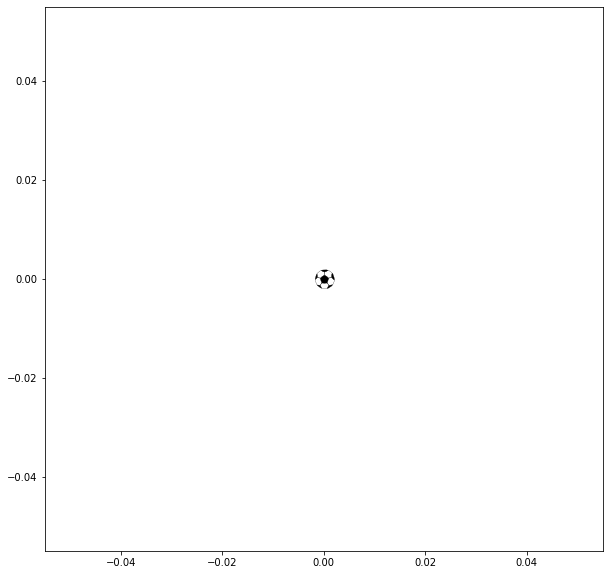

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot([0],[0], marker=football_pentagon,markersize=20,markerfacecolor='black',
        markeredgecolor='black',linestyle='None',
        markeredgewidth=0.25)
ax.plot([0],[0], marker=football_hexagon,markersize=20,markerfacecolor='None',
        markeredgecolor='black',linestyle='None',
        markeredgewidth=0.25)

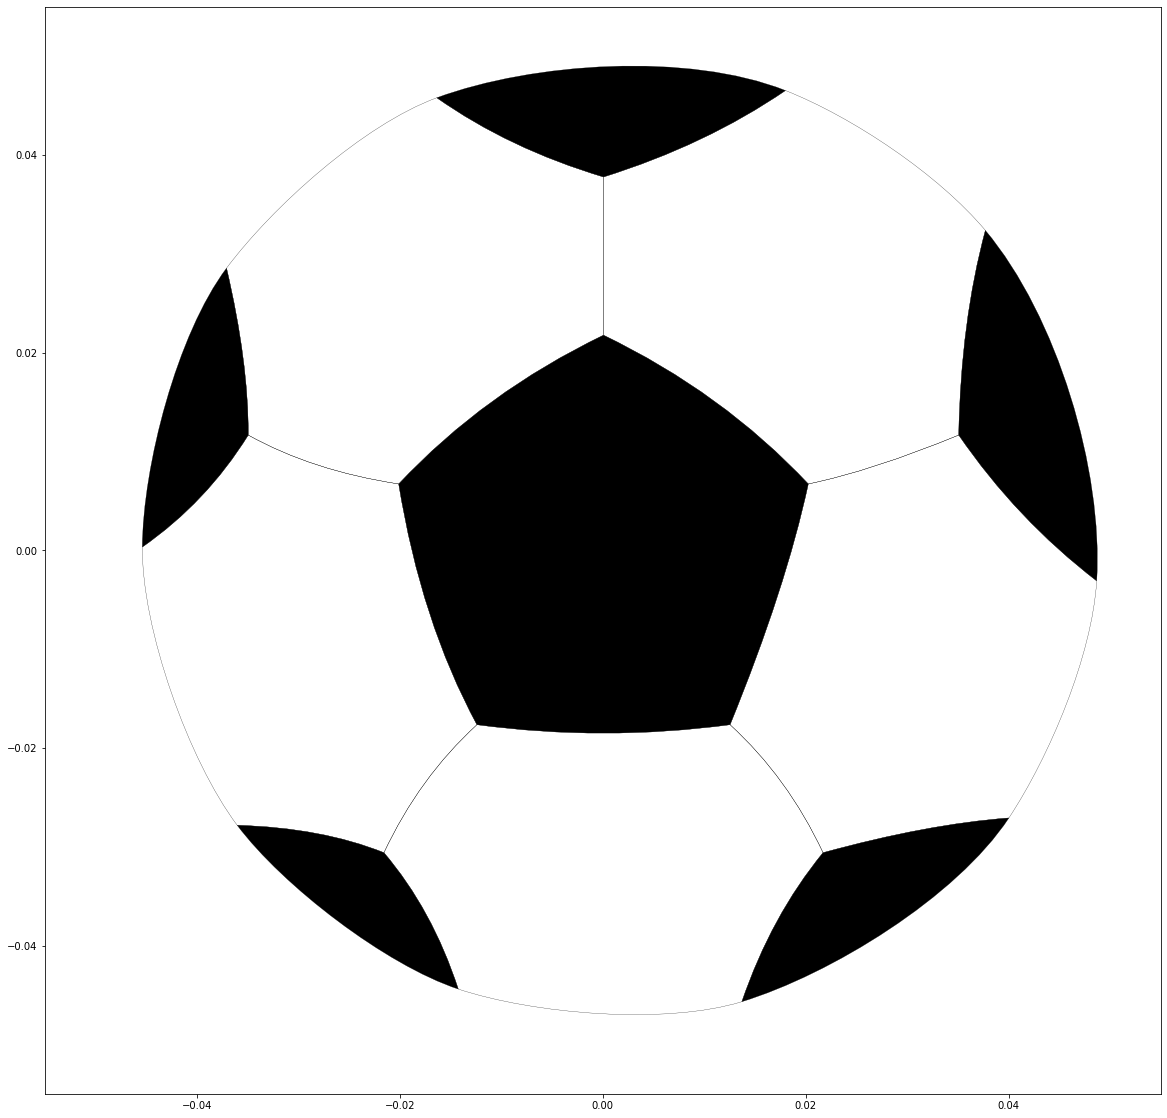

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
ax.plot([0],[0], marker=football_pentagon,markersize=1000,markerfacecolor='black',
        markeredgecolor='black',linestyle='None',
        markeredgewidth=0.25)
ax.plot([0],[0], marker=football_hexagon,markersize=1000,markerfacecolor='None',
        markeredgecolor='black',linestyle='None',
        markeredgewidth=0.25)

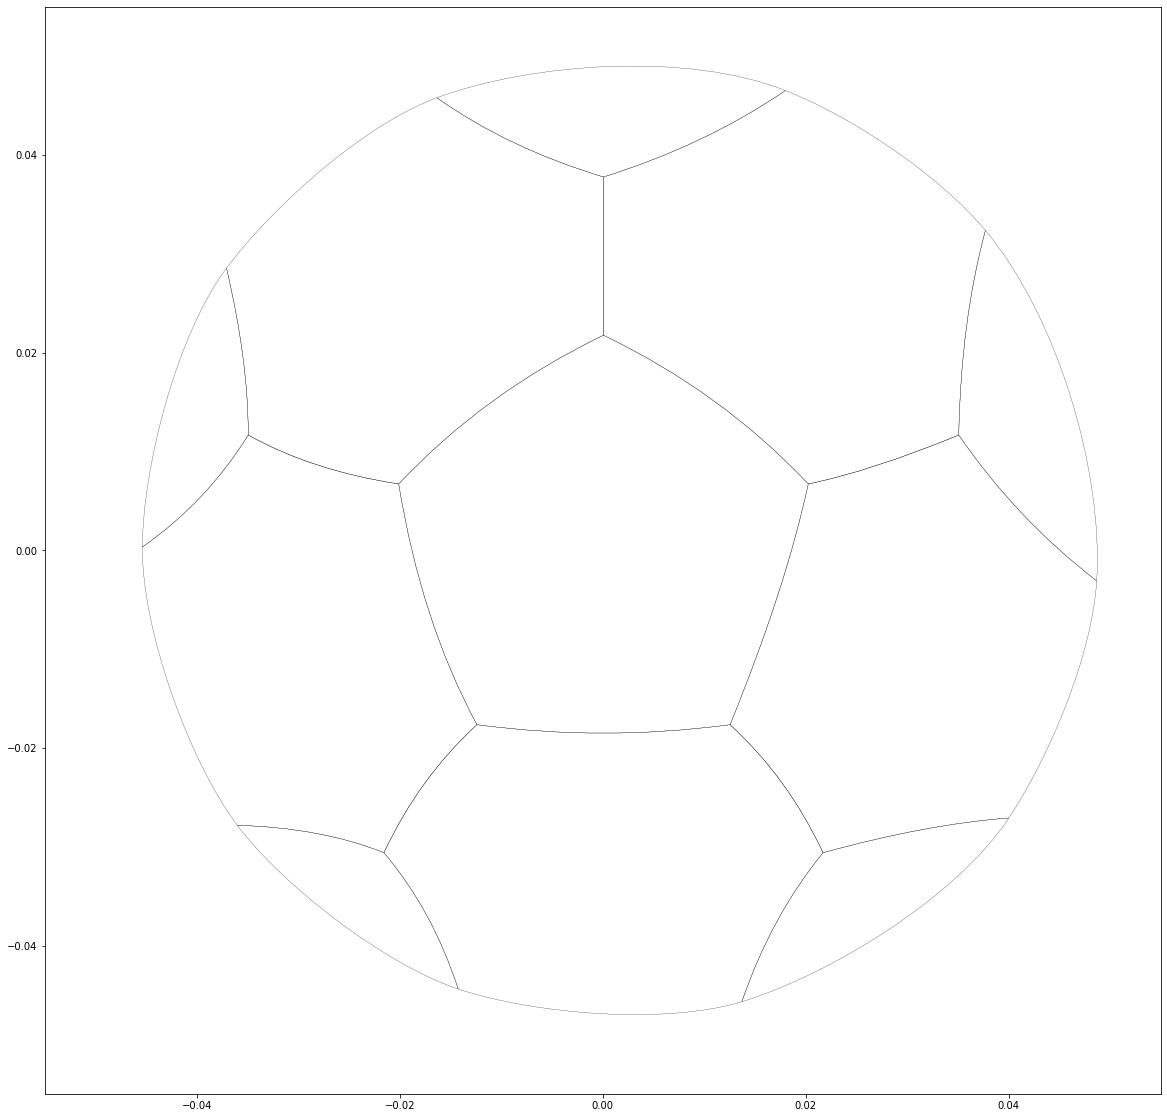

In [41]:
fig, ax = plt.subplots(figsize=(20,20))
ax.plot([0],[0], marker=football_pentagon,markersize=1000,markerfacecolor='None',
        markeredgecolor='black',linestyle='None',
        markeredgewidth=0.25)
ax.plot([0],[0], marker=football_hexagon,markersize=1000,markerfacecolor='None',
        markeredgecolor='black',linestyle='None',
        markeredgewidth=0.25)